https://docs.google.com/presentation/d/1xgsxPhjUbDtOPeRThzuh8o6mJ7oWX8mUzJ1XBIM1PcU/edit?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
AMETHYSTS = "AMETHYSTS"
STARFRUIT = "STARFRUIT"

price_2 = pd.read_csv('data/prices_round_1_day_-2.csv', sep=';')
price_1 = pd.read_csv('data/prices_round_1_day_-1.csv', sep=';')
price_0 = pd.read_csv('data/prices_round_1_day_0.csv', sep=';')

trades_2 = pd.read_csv('data/trades_round_1_day_-2_nn.csv', sep=';')
trades_1 = pd.read_csv('data/trades_round_1_day_-1_nn.csv', sep=';')
trades_0 = pd.read_csv('data/trades_round_1_day_0_nn.csv', sep=';')

all_prices = pd.concat([price_2, price_1, price_0])
all_trades = pd.concat([trades_2, trades_1, trades_0])

prices = {"all": all_prices}
trades = {"all": all_trades}
products = list(all_prices['product'].unique())
for product in products:
    prices[product] = all_prices[all_prices['product'] == product]
    trades[product] = all_trades[all_trades['symbol'] == product]

In [3]:
prices[AMETHYSTS].head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
5,-2,200,AMETHYSTS,9996,1,9995.0,30.0,NaN,NaN,10004,1,10005.0,30.0,NaN,NaN,10000.0,0.0
6,-2,300,AMETHYSTS,9996,1,9995.0,26.0,NaN,NaN,10004,1,10005.0,26.0,NaN,NaN,10000.0,0.0
8,-2,400,AMETHYSTS,9995,20,NaN,NaN,NaN,NaN,9998,3,10002.0,9.0,10005.0,20.0,9996.5,0.0


# Amethysts

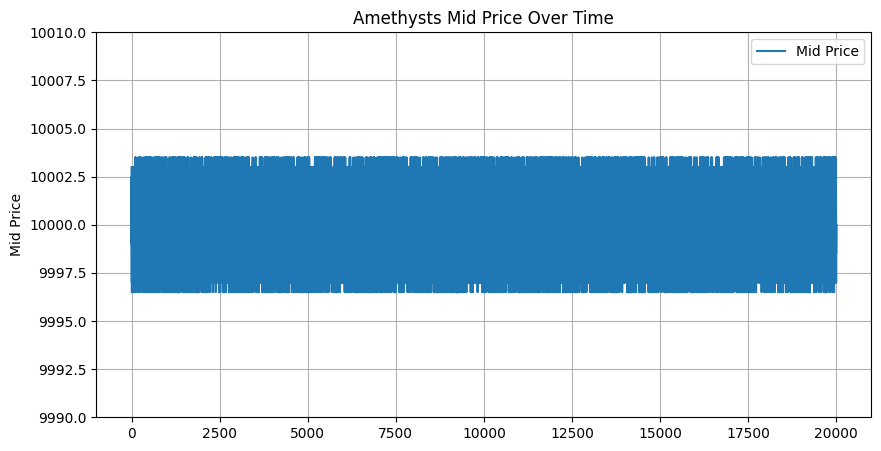

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(prices[AMETHYSTS]["mid_price"], label="Mid Price")
plt.title("Amethysts Mid Price Over Time")
plt.ylabel("Mid Price")
plt.ylim(10_000 - 10, 10_000 + 10)
plt.legend()
plt.grid(True)
plt.show()

# Starfruit

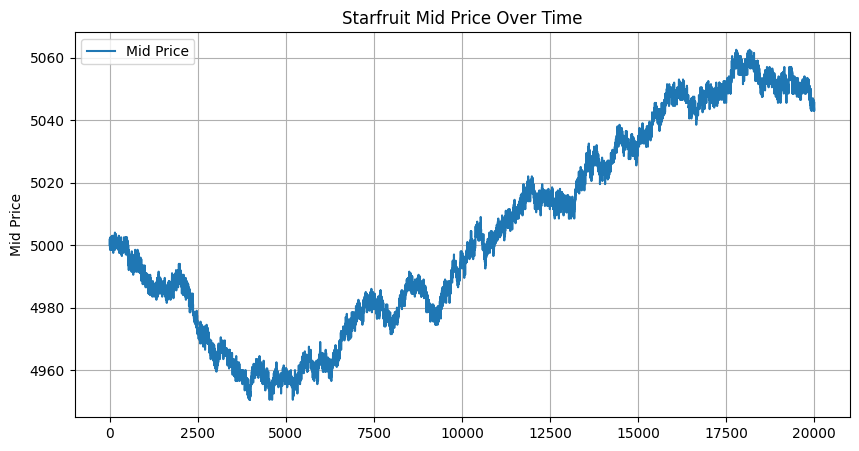

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(price_2[price_2["product"] == STARFRUIT]["mid_price"], label="Mid Price")
plt.title("Starfruit Mid Price Over Time")
plt.ylabel("Mid Price")
plt.legend()
plt.grid(True)
plt.show()

## Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
# CONFIGS

previous_timesteps = 5
future_timesteps = 5
model = Lasso()

In [8]:
# FEATURE EXTRACTION
features = pd.DataFrame()
df = prices[STARFRUIT]

total_bid_volume = (
    df['bid_volume_1'].fillna(0) +
    df['bid_volume_2'].fillna(0) +
    df['bid_volume_3'].fillna(0)
)
total_ask_volume = (
    df['ask_volume_1'].fillna(0) +
    df['ask_volume_2'].fillna(0) +
    df['ask_volume_3'].fillna(0)
)

# Spread: The difference between the ask price and the bid price.
features['spread'] = df['ask_price_1'] - df['bid_price_1']

# Weighted Price: Weighted price for bids and asks
features['weighted_bid_price'] = (
    df['bid_price_1'].fillna(0) * df['bid_volume_1'].fillna(0) +
    df['bid_price_2'].fillna(0) * df['bid_volume_2'].fillna(0) +
    df['bid_price_3'].fillna(0) * df['bid_volume_3'].fillna(0)
) / total_bid_volume

features['weighted_ask_price'] = (
    df['ask_price_1'].fillna(0) * df['ask_volume_1'].fillna(0) +
    df['ask_price_2'].fillna(0) * df['ask_volume_2'].fillna(0) +
    df['ask_price_3'].fillna(0) * df['ask_volume_3'].fillna(0)
) / total_ask_volume

# Volume Imbalance: The difference between total bid volume and total ask volume
features['volume_imbalance'] = total_bid_volume - total_ask_volume

# Depth: Sum of volumes at the best three bid and ask levels.
features['bid_depth'] = total_bid_volume
features['ask_depth'] = total_ask_volume

# Previous Timesteps:
for lag in range(previous_timesteps + 1):
    features[f'lag_{lag}'] = df['mid_price'].shift(lag)

# Future Timesteps:
features['future'] = df['mid_price'].shift(-future_timesteps)
features = features.dropna()  # Remove rows with missing values

# print(features.tail())

In [9]:
# CREATE X AND y

X = features.drop(columns=['future'])
y = features['future']

split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [10]:
# PREDICTIONS

model.fit(X_train, y_train)
predictions = model.predict(X_test)

# predictions = X_test["lag_0"]

In [11]:
# ERROR

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, predictions)
print("R2 Score:", r2)

Mean Squared Error: 2.281340342128804
R2 Score: 0.9736413940083409


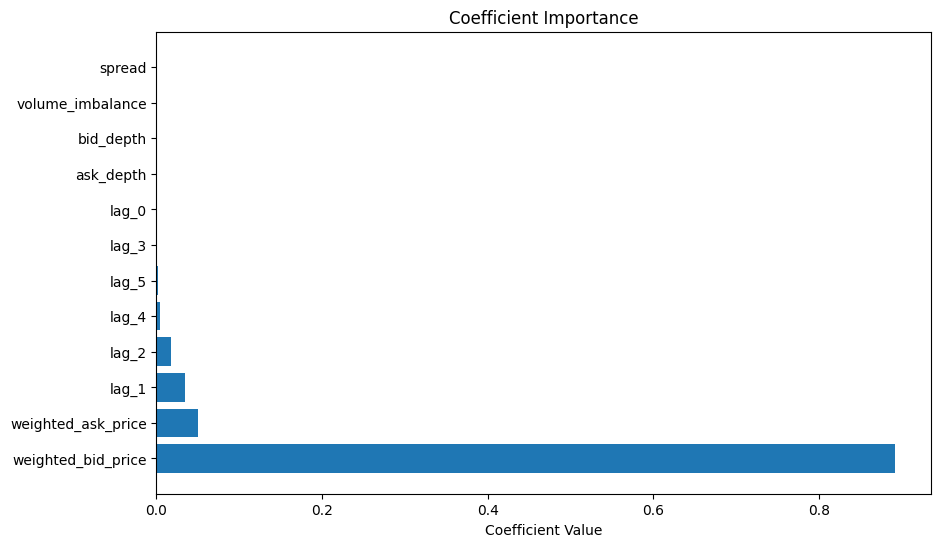

weighted_bid_price  : 0.8912511197162724
weighted_ask_price  : 0.049647884371205826
lag_1               : 0.03427220650606391
lag_2               : 0.01787427982366641
lag_4               : 0.004676731405805944
lag_5               : 0.0016497241715515542
lag_3               : 0.0
lag_0               : 0.0
ask_depth           : 0.0
bid_depth           : -0.0
volume_imbalance    : -0.0
spread              : 0.0


In [12]:
# COEFFICIENTS
def plot_coefficients(model, feature_names):
    # Get coefficients and feature names
    coefficients = model.coef_
    names = feature_names
    # Sort coefficients and names by absolute value
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]
    sorted_coefficients = coefficients[sorted_indices]
    sorted_names = [names[i] for i in sorted_indices]
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_names)), sorted_coefficients, align='center')
    plt.yticks(range(len(sorted_names)), sorted_names)
    plt.xlabel('Coefficient Value')
    plt.title('Coefficient Importance')
    plt.show()

    for i, (coef, column) in enumerate(zip(sorted_coefficients, sorted_names)):
        print(f"{column.ljust(20)}: {coef}")

plot_coefficients(model, X.columns)

## Random Walk

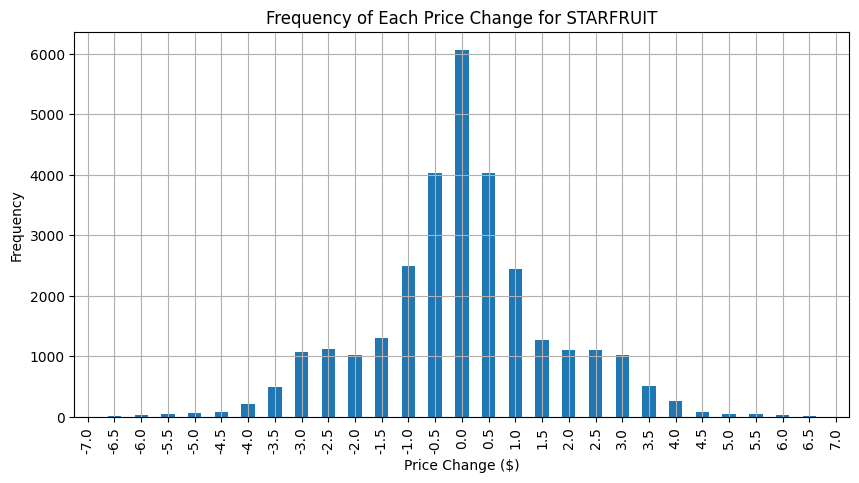

In [13]:
delta = prices[STARFRUIT]["mid_price"] - prices[STARFRUIT]["mid_price"].shift(1)
delta = delta.value_counts().sort_index()

plt.figure(figsize=(10, 5))
delta.plot(kind='bar')
plt.title('Frequency of Each Price Change for STARFRUIT')
plt.xlabel('Price Change ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller

def hurst_exponent(ts, max_lags=1000):
    lags = range(2, max_lags)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    return poly[0]*2.0

df = price_2[price_2['product'] == "STARFRUIT"]["mid_price"]
result = adfuller(df)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print("The series is likely mean-reverting (stationary).")
else:
    print("The series is likely not mean-reverting (non-stationary).")
print()

    
hurst = hurst_exponent(df.values)
print("Hurst Exponent:", hurst)

ADF Statistic: -0.031303
p-value: 0.955866
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The series is likely not mean-reverting (non-stationary).

Hurst Exponent: 0.47444873701069235
